## Description, Imports and Path 

In [1]:
"""
Python Version: 3.10

Project Title: "Mirror effect of genomic deletions and duplications on cognitive ability across the human cerebral cortex" 🧠

Rationale:
The cerebral-cortex gene-set burden analysis (CC-GSBA) is a statistical method designed to estimate the association between Copy Number Variants (CNVs) and a continuous cognitive ability phenotype. It aggregates the effect of rare CNVs within functionally brain-related gene sets to increase statistical power and identify key biological pathways underlying cognitive ability.

Script Description:
This script performs a statistical analysis using simulated (toy) datasets for the individuals, their CNV counts, and the cognitive ability phenotype. The analysis is run against a real gene set dataset, which contains the actual genomic coordinates and gene information. This approach allows for the development and testing of the analytical pipeline without requiring access to sensitive or large-scale human genetic data.

The analysis pipeline for each gene set involves the following steps:

CNV Count Generation: For each individual in the toy dataset, a count is calculated for CNV events overlapping with genes both "inside" and "outside" the specified brain gene set.

Regression Model Fitting: A regression model is fitted using Generalized Least Squares (GLS) to assess the effect of the "inside" and "outside" CNV counts on the toy cognitive ability phenotype (phenotype1).

Multithreading Across Gene Sets: The analysis is parallelized across multiple gene sets using the multiprocessing library to optimize performance in high-performance computing (HPC) environments.

The final output is a structured, tab-separated file containing the effect size, standard deviation, and p-value for each gene set's "inside" and "outside" effect.
"""

# --- 1. Library Imports ---
import pandas as pd
import numpy as np
import statsmodels.api as sm
import patsy
import time
import matplotlib.pyplot as plt
from multiprocessing import Pool
import os
import sys
import time
#from statsmodels.regression.linear_model import GLS

# --- 2. Toy Datasets ---

PHENOTYPE_FILE = "Phenotypic_info_Toy/phenotype1_toy.tsv"
PHENOTYPE_COLUMN = "phenotype1"
PHENOTYPE_NAME = "phenotype1_toy"


GENE_SET_DIRECTORY = "GeneSets/GeneSet_Glasser_Z0p5"
GENE_SET_NAME = "GeneSet_Glasser_Z0p5"
COVARIATES = ' + age + Sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10'

# File paths for input and output data.
CURRENT_DIR = os.getcwd()

PATH_GENE_FILES = os.path.join(CURRENT_DIR, GENE_SET_DIRECTORY)
PATH_GENE_INFO = os.path.join(CURRENT_DIR,"Genotypic_info_Toy", "cnv_gene_df_toy.tsv")
PATH_CNV_INDIVIDUAL = os.path.join(CURRENT_DIR,"Genotypic_info_Toy", "cnv_individual_df_toy.tsv")
PATH_CLEAN_DATA = os.path.join(CURRENT_DIR, "Phenotypic_info_Toy","clean_individual_df_toy.tsv")

OUTPUT_PATH = os.path.join(CURRENT_DIR,'Outcome_Toy', f"Effect_sizes_{GENE_SET_NAME}_{PHENOTYPE_NAME}.tsv")

# Number of CPU cores for parallel processing.
CPU_COUNT = int(os.environ.get("SLURM_CPUS_PER_TASK", 4))

print("Notebook setup complete. Proceed to the next cell to load data.")

Notebook setup complete. Proceed to the next cell to load data.


## Data Loading and Preprocessing

In [2]:
print("Loading all required data files...")

cnv_individual_df = pd.read_csv(PATH_CNV_INDIVIDUAL, sep='\t')
cnv_individual_df['individual'] = cnv_individual_df['individual'].str[:7].astype(str)

phenotype_individual_df = pd.read_csv(PHENOTYPE_FILE, sep='\t')
phenotype_individual_df['individual'] = phenotype_individual_df['individual'].astype(str)

cnv_gene_df = pd.read_csv(
    PATH_GENE_INFO,
    sep='\t', usecols=['CHR', 'START', 'STOP', 'TYPE', 'proportion_gene_overlap', 'gene_id']
)

clean_individual_df = pd.read_csv(PATH_CLEAN_DATA, usecols=["individual", "Ancestry"],sep='\t')
clean_individual_df['individual'] = clean_individual_df['individual'].str[:7].astype(str)

# Filter for individuals with 'EUR' ancestry and merge with phenotype data
phenotype_individual_df = pd.merge(phenotype_individual_df, clean_individual_df[clean_individual_df['Ancestry'] == 'EUR'], on='individual', how='inner')

print("Data loading complete.")


Loading all required data files...
Data loading complete.


## Subset of Phenotypic information

In [3]:
phenotype_individual_df.head(5)


individual   age  Sex      PC1       PC2      PC3       PC4        PC5  \
0       ID_1  60.0    0 -13.7374  0.997419  0.64579  1.290620 -11.294800   
1       ID_3  70.0    0 -13.1445  4.447320 -3.72131  3.187150  -6.740280   
2       ID_4  57.0    0 -10.8553  1.502140 -6.82240  0.375296   9.392060   
3       ID_5  46.0    1 -12.3126       NaN -2.10645 -2.448810  -0.369904   
4       ID_6  58.0    1 -13.2459  2.703010 -1.36776 -2.554130   5.757240   

        PC6        PC7      PC8       PC9     PC10  phenotype1 Ancestry  
0 -2.059460  -2.839110  1.37131  0.944355  2.44901   -0.769989      EUR  
1  0.910154   2.244110  2.43267  4.542520 -3.61374   -0.456116      EUR  
2  0.437707   0.735077 -1.20505  1.824390 -2.65293    0.181425      EUR  
3 -2.406790  -1.444140  0.69737       NaN -0.19932    0.595024      EUR  
4  1.518050 -23.113200 -0.01130 -1.262050  4.16084   -0.557418      EUR

In [4]:
print(phenotype_individual_df.shape)

(803, 15)


## Subset of Genotypic information : CNV-Gene

In [5]:
cnv_gene_df.head(5)

gene_id    CHR      START       STOP TYPE  proportion_gene_overlap
0  ENSG00000187555  chr20   49574017   49912726  DEL                 0.166811
1  ENSG00000166105   chr1  169740986  170528913  DUP                 1.000000
2  ENSG00000176256   chr1  169740986  169856661  DEL                 0.950124
3  ENSG00000243137   chr1  169548053  170665664  DUP                 1.000000
4  ENSG00000049130   chr1  169740986  170528913  DUP                 1.000000

In [6]:
cnv_gene_df.shape

(313455, 6)

## Subset of Genotypic information : CNV-Individual

In [7]:
cnv_individual_df.head(5)

individual    CHR      START       STOP TYPE
0      ID_38  chr10   68456145   68550490  DEL
1     ID_474  chr11   91481728   91669648  DEL
2     ID_523  chr18   38514376   38681926  DEL
3     ID_597  chr18    7067652    7575300  DUP
4     ID_947   chr5  147968858  148319491  DUP

In [8]:
cnv_individual_df.shape

(396, 5)

## Subset of Subset of Individuals Meeting Quality Control

In [9]:
clean_individual_df.head(5)

individual Ancestry
0     ID_104      EUR
1     ID_517      EUR
2     ID_617      EUR
3     ID_737      EUR
4     ID_936      EUR

In [10]:
clean_individual_df.shape

(850, 2)

## Functions

In [15]:
# ==================================================================================================
## Data Processing and Aggregation
# ==================================================================================================

def annotate_gene_set_status(data, gene_column_name, gene_list):
    """
    Annotates genes as being either 'inside' or 'outside' a specified gene list.

    This function adds two new boolean-like columns, 'inside' and 'outside', to a DataFrame
    based on whether a gene identifier in a specified column exists in a given gene list.
    The values are represented as integers (1 for true, 0 for false), which is useful for
    downstream statistical analysis.

    Args:
        data (pd.DataFrame): The input DataFrame containing gene-level data. It must include
                             a column with gene identifiers (e.g., ENSG IDs).
        gene_column_name (str): The name of the column in `data` that contains the gene
                                identifiers to be checked.
        gene_list (list): A list of gene identifiers that define the gene set of interest.

    Returns:
        pd.DataFrame: The original DataFrame with the new 'inside' and 'outside' columns
                      added.
    """
    data["inside"] = data[gene_column_name].isin(gene_list).astype(int)
    data["outside"] = (~data[gene_column_name].isin(gene_list)).astype(int)
    return data

def aggregate_cnv_counts(cnv_individual_df, cnv_gene_df, phenotype_individual_df):
    """
    Aggregates CNV counts for each individual based on genes inside and outside a set.

    This function processes individual-level and gene-level CNV data to generate a summary
    of CNV counts per individual. It counts events (both deletions and duplications) that
    fall within ('inside') and outside a defined gene set. The final output is merged with
    phenotype data for statistical modeling.

    Args:
        cnv_individual_df (pd.DataFrame): DataFrame with individual-level CNV data. It is
                                          expected to have columns like 'individual', 'CHR',
                                          'START', 'STOP', and 'TYPE'.
        cnv_gene_df (pd.DataFrame): DataFrame with gene-level CNV data and annotations. It
                                    is expected to have the 'inside' and 'outside' columns
                                    added by `annotate_gene_set_status`, as well as 'CHR',
                                    'START', 'STOP', and 'TYPE'.
        phenotype_individual_df (pd.DataFrame): DataFrame with individual phenotype and
                                                covariate data. It must have an 'individual'
                                                column to serve as the key for merging.

    Returns:
        pd.DataFrame: A merged DataFrame with columns for individual-level phenotype data
                      and aggregated CNV counts (e.g., 'inside_DEL', 'outside_DUP'). Missing
                      values in count columns are filled with 0.
    """
    cnv_gene_del_df = cnv_gene_df[cnv_gene_df["TYPE"] == "DEL"]
    cnv_gene_dup_df = cnv_gene_df[cnv_gene_df["TYPE"] == "DUP"]
    
    cnv_individual_del_df = cnv_individual_df[cnv_individual_df["TYPE"] == "DEL"]
    cnv_individual_dup_df = cnv_individual_df[cnv_individual_df["TYPE"] == "DUP"]

    def process_cnv_type(cnv_subset, gene_subset):
        """Helper function to aggregate counts for a single CNV type (DEL or DUP)."""
        gene_subset = gene_subset.copy()
        gene_subset['position'] = gene_subset.apply(lambda row: f"{row['CHR']}--{row['START']}--{row['STOP']}", axis=1)
        gene_subset.set_index('position', inplace=True)
        gene_counts = gene_subset[['inside', 'outside']].groupby(level="position").sum()

        cnv_subset = cnv_subset.copy()
        cnv_subset['position'] = cnv_subset.apply(lambda row: f"{row['CHR']}--{row['START']}--{row['STOP']}", axis=1)
        cnv_positions = cnv_subset[['position', 'individual']]

        merged_counts = pd.merge(cnv_positions, gene_counts, on="position", how="outer")
        individual_counts = merged_counts[['inside', 'outside']]
        individual_counts.index = merged_counts["individual"]
        return individual_counts.groupby(level="individual").sum()

    count_individual_del_cnvs = process_cnv_type(cnv_individual_del_df, cnv_gene_del_df)
    count_individual_dup_cnvs = process_cnv_type(cnv_individual_dup_df, cnv_gene_dup_df)

    final_counts = pd.merge(count_individual_dup_cnvs, count_individual_del_cnvs, on="individual", how="outer", suffixes=('_DUP', '_DEL'))
    
    final_counts.columns = [
        "inside_DUP", "outside_DUP",
        "inside_DEL", "outside_DEL"
    ]

    final_counts = pd.merge(phenotype_individual_df, final_counts, on="individual", how="inner")
    final_counts.fillna(0, inplace=True)
    
    return final_counts


# ==================================================================================================
## Statistical Modeling (Linear regression for a Continues Trait)
# ==================================================================================================
def fit_model_and_extract_results(data, cnv_type, pheno_col, covariates):
    """
    Fits a Generalized Least Squares (GLS) regression model and extracts key results.

    This function constructs a regression formula and uses the `patsy` library to create
    a design matrix, which is more robust for handling categorical covariates. It then
    fits a GLS model using `statsmodels` to assess the effect of CNV counts on a
    continuous phenotype. The function is designed to handle potential model failures
    gracefully by returning a structured DataFrame with NaN values.

    Args:
        data (pd.DataFrame): The input DataFrame containing all variables for the model.
        cnv_type (str): The CNV type, either "DEL" for deletion or "DUP" for duplication.
        pheno_col (str): The name of the continuous phenotype column in `data`.
        covariates (str): A string of additional covariates to include in the formula,
                          e.g., " + C(Sex) + C(Ancestry)".

    Returns:
        pd.DataFrame: A DataFrame containing the effect size, standard error, and
                      p-value for each model parameter. Returns a placeholder row with
                      NaN values if the model fails to converge or fit.
    """
    formula = f"{pheno_col} ~ inside_{cnv_type} + outside_{cnv_type}{covariates}"
    
    try:
        y, X = patsy.dmatrices(formula, data, return_type='dataframe')
        
        # Run GLS for continuous traits
        regression_results = sm.GLS(y, X).fit()
        
        results_df = pd.DataFrame({
            'Effectsize': regression_results.params.values,
            'se': regression_results.bse.values,
            'pvalue': regression_results.pvalues.values
        }, index=regression_results.params.index)
        
        return results_df
    except Exception as e:
        print(f"Error running model for {cnv_type}: {e}")
        # Return a placeholder DataFrame with the expected index
        return pd.DataFrame({'Effectsize': [np.nan], 'se': [np.nan], 'pvalue': [np.nan]}, 
                            index=[f'inside_{cnv_type}'])

# ==================================================================================================
## Main Analysis Workflow
# ==================================================================================================

def Association_Test(list_name):
    """
    Orchestrates the primary analysis for a single gene list.

    This function manages the entire workflow for a given gene set: it loads the gene
    list, processes the data, aggregates CNV counts, and then fits regression models
    for both deletions (DEL) and duplications (DUP). It is the main driver of the
    initial association analysis.

    Args:
        list_name (str): The file name of the gene list to be processed.

    Returns:
        pd.DataFrame: A summary DataFrame containing the regression results (effect size,
                      standard error, and p-value) for both the DEL and DUP CNV types
                      for the specified gene list. Returns an empty DataFrame on error.
    """
    print(f"Processing gene list: {list_name}")
    start_time = time.time()
    
    try:
        gene_list = pd.read_csv(f"{PATH_GENE_FILES}/{list_name}", sep='\t')
        gene_list.columns = ["gene_id"]
        
        gene_info_subset = cnv_gene_df[cnv_gene_df["proportion_gene_overlap"] >= 1].copy()
        gene_info_with_indicators = annotate_gene_set_status(
            gene_info_subset, "gene_id", gene_list.iloc[:, 0].tolist()
        )
        
        combined_counts_df = aggregate_cnv_counts(
            cnv_individual_df,
            gene_info_with_indicators,
            phenotype_individual_df
        )
        
        cleaned_data = combined_counts_df.dropna(subset=[PHENOTYPE_COLUMN])
        
        final_results = []
        list_name = list_name.replace('.tsv', '')
        
        for cnv_type in ["DEL", "DUP"]:
            results_df = fit_model_and_extract_results(
                data=cleaned_data,
                cnv_type=cnv_type,
                pheno_col=PHENOTYPE_COLUMN,
                covariates=COVARIATES
            )
            
            target_row_name = f'inside_{cnv_type}'
            if target_row_name in results_df.index:
                result_row = results_df.loc[[target_row_name]].copy()
                result_row['TYPE'] = cnv_type
                result_row['gene_list_name'] = list_name
                final_results.append(result_row)
            else:
                placeholder_row = pd.DataFrame([np.nan, np.nan, np.nan, cnv_type, list_name],
                                               index=['Effectsize', 'se', 'pvalue', 'TYPE', 'gene_list_name']).T
                final_results.append(placeholder_row)

        if final_results:
            final_list_summary = pd.concat(final_results, ignore_index=True)
            print(f"Finished processing {list_name} in {(time.time() - start_time):.2f} seconds.")
            return final_list_summary
        else:
            print(f"No results generated for {list_name}.")
            return pd.DataFrame()
    
    except Exception as e:
        print(f"An error occurred while processing {list_name}: {e}")
        return pd.DataFrame()

# ==================================================================================================
## Permutation Test
# ==================================================================================================

def run_permutation_test(data, num_permutations, cnv_type, pheno_col, covariates, observed_effect_size):
    """
    Performs a permutation test by shuffling the phenotype column and re-fitting the model.

    This function generates a null distribution of effect sizes by randomly shuffling the
    phenotype data and re-running the regression model many times. It then calculates a
    permutation p-value by comparing the observed effect size to this null distribution.
    It is designed to be robust to model failures during permutation, filtering out any
    failed runs before calculating the final statistics.

    Args:
        data (pd.DataFrame): The DataFrame with CNV counts and phenotype data.
        num_permutations (int): The number of times to shuffle the data and re-run the
                                model to create the null distribution.
        cnv_type (str): The CNV type ("DEL" or "DUP").
        pheno_col (str): The name of the phenotype column.
        covariates (str): A string of additional covariates for the formula.
        observed_effect_size (float): The effect size from the original, un-shuffled data.

    Returns:
        tuple: A tuple containing:
               - An array of the null effect sizes from successful permutations.
               - The permutation p-value.
               - A tuple representing the 95% confidence interval of the null distribution.
               Returns empty arrays and NaNs if no successful permutations are generated.
    """
    null_effect_sizes = []
    shuffled_data = data.copy()

    for _ in range(num_permutations):
        # Shuffle the phenotype column
        shuffled_data[pheno_col] = np.random.permutation(shuffled_data[pheno_col])
        
        # Fit the model with the shuffled data
        perm_results_df = fit_model_and_extract_results(
            data=shuffled_data,
            cnv_type=cnv_type,
            pheno_col=pheno_col,
            covariates=covariates
        )
        
        target_row_name = f'inside_{cnv_type}'
        
        # Check if the target effect size exists and is not NaN
        if not perm_results_df.empty and target_row_name in perm_results_df.index and not pd.isna(perm_results_df.loc[target_row_name, 'Effectsize']):
            null_effect_sizes.append(perm_results_df.loc[target_row_name, 'Effectsize'])
        else:
            # If the model fails or result is missing, append NaN
            null_effect_sizes.append(np.nan)

    null_effect_sizes = np.array(null_effect_sizes)
    
    # Filter out NaNs for p-value and CI calculation
    valid_null_effects = null_effect_sizes[~np.isnan(null_effect_sizes)]

    if len(valid_null_effects) == 0:
        print("Warning: All permutation models failed. Cannot compute p-value or CI.")
        return np.array([]), np.nan, (np.nan, np.nan)

    # Compute p-value for a two-tailed test
    p_value = (np.sum(np.abs(valid_null_effects) >= np.abs(observed_effect_size)) + 1) / (len(valid_null_effects) + 1)
    
    # Compute 95% confidence interval (CI) from the null distribution
    ci_lower = np.quantile(valid_null_effects, 0.025)
    ci_upper = np.quantile(valid_null_effects, 0.975)

    return valid_null_effects, p_value, (ci_lower, ci_upper)

def plot_permutation_results(null_effects, observed_effect, title):
    """
    Generates a histogram of the null effects with a vertical line for the observed effect size.

    This function creates a visualization of the permutation test results. It plots a
    histogram of the null effect sizes generated by random shuffling and adds a vertical
    line to show where the original observed effect size falls within this distribution.

    Args:
        null_effects (np.array): An array of effect sizes from the permutation tests.
        observed_effect (float): The effect size from the original, un-shuffled data.
        title (str): The title for the plot.
    """
    plt.figure(figsize=(10, 6))
    
    # Create the histogram
    plt.hist(null_effects, bins=50, density=True, color='orange', edgecolor='darkgrey', alpha=0.7)
    
    # Optional: Add a kernel density estimate (KDE) line
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(null_effects)
        x_vals = np.linspace(min(null_effects), max(null_effects), 1000)
        plt.plot(x_vals, kde(x_vals), color='darkblue')
    except ImportError:
        pass # Skip KDE if scipy is not installed
        
    plt.axvline(x=observed_effect, color='red', linestyle='--', linewidth=2, label=f'Observed Effect Size: {observed_effect:.4f}')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Effect Size', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def Association_Test_Permutation(list_name):
    """
    Orchestrates the analysis for a single gene list, including permutation tests.

    This function serves as the main entry point for running the complete analysis
    for a given gene set. It first performs the primary association test to get the
    observed effect size, then runs a permutation test to assess its significance
    and generates a plot. The function handles potential errors and returns a complete
    summary DataFrame.

    Args:
        list_name (str): The name of the gene list file to be processed.

    Returns:
        pd.DataFrame: A summary DataFrame of the final regression and permutation
                      results. Returns an empty DataFrame on unrecoverable errors.
    """
    print(f"Processing gene list: {list_name}")
    start_time = time.time()
    
    try:
        gene_list = pd.read_csv(f"{PATH_GENE_FILES}/{list_name}", sep='\t')
        gene_list.columns = ["gene_id"]
        
        gene_info_subset = cnv_gene_df[cnv_gene_df["proportion_gene_overlap"] >= 1].copy()
        gene_info_with_indicators = annotate_gene_set_status(
            gene_info_subset, "gene_id", gene_list.iloc[:, 0].tolist()
        )
        
        combined_counts_df = aggregate_cnv_counts(
            cnv_individual_df,
            gene_info_with_indicators,
            phenotype_individual_df
        )
        
        cleaned_data = combined_counts_df.dropna(subset=[PHENOTYPE_COLUMN])
        
        final_results = []
        # Remove .tsv suffix for the final output
        list_name = list_name.replace('.tsv', '')
        for cnv_type in ["DEL", "DUP"]:
            observed_results_df = fit_model_and_extract_results(
                data=cleaned_data,
                cnv_type=cnv_type,
                pheno_col=PHENOTYPE_COLUMN,
                covariates=COVARIATES
            )
            
            target_row_name = f'inside_{cnv_type}'
            
            if observed_results_df.empty or target_row_name not in observed_results_df.index or pd.isna(observed_results_df.loc[target_row_name, 'Effectsize']):
                print(f"Skipping permutation test for {cnv_type} due to model failure or missing results.")
                result_row = pd.DataFrame([np.nan, np.nan, np.nan, cnv_type, list_name],
                                          index=['Effectsize', 'se', 'pvalue', 'TYPE', 'gene_list_name']).T
                result_row['pvalue_permutation'] = np.nan
                result_row['CI_lower'] = np.nan
                result_row['CI_upper'] = np.nan
                final_results.append(result_row)
                continue
            
            observed_effect_size = observed_results_df.loc[target_row_name, 'Effectsize']
            
            num_permutations = 1000  # Increased for more robust results
            null_effects, p_value, ci = run_permutation_test(
                data=cleaned_data,
                num_permutations=num_permutations,
                cnv_type=cnv_type,
                pheno_col=PHENOTYPE_COLUMN,
                covariates=COVARIATES,
                observed_effect_size=observed_effect_size
            )
            
            result_row = observed_results_df.loc[[target_row_name]].copy()
            result_row.insert(loc=3, column='pvalue_permutation', value=p_value)
            result_row.insert(loc=4, column='CI_lower', value=ci[0])
            result_row.insert(loc=5, column='CI_upper', value=ci[1])
            result_row['TYPE'] = cnv_type
            result_row['gene_list_name'] = list_name
            final_results.append(result_row)
            
            if null_effects is not None and len(null_effects) > 0:
                plot_title = f'Null Distribution of Effect Sizes for {list_name} ({cnv_type})'
                plot_permutation_results(null_effects, observed_effect_size, plot_title)

        if not final_results:
            print(f"No results to concatenate for {list_name}.")
            return pd.DataFrame()
        
        final_list_summary = pd.concat(final_results, ignore_index=True)
        print(f"Finished processing {list_name} in {(time.time() - start_time):.2f} seconds.")
        return final_list_summary
        
    except Exception as e:
        print(f"An error occurred while processing {list_name}: {e}")
        return pd.DataFrame()

## Execution and Output

### Main Analaysis 

In [12]:
if __name__ == '__main__':
    
    print("Beginning the gene set association analysis...")

    list_of_gene_files = [f for f in os.listdir(PATH_GENE_FILES) if f.endswith(".tsv")]
    
    start_all = time.time()
    
    with Pool(CPU_COUNT) as pool:
        results = pool.map(Association_Test, list_of_gene_files)
    
    final_results_df = pd.concat(results, ignore_index=True)
    
    if not final_results_df.empty:
        final_results_df.to_csv(OUTPUT_PATH, sep="\t", index=False)
        print(f"Analysis successfully completed. Results saved to: {OUTPUT_PATH}")
    else:
        print("No results were generated. The process may have failed.")
        
    print(f"Total execution time: {(time.time() - start_all):.2f} seconds.")

Beginning the gene set association analysis...
Processing gene list: L_PHT.tsvProcessing gene list: L_a9.46v.tsvProcessing gene list: L_AIP.tsvProcessing gene list: L_a24.tsvProcessing gene list: L_46.tsv




Processing gene list: L_PCV.tsv
Finished processing L_46 in 1.77 seconds.
Processing gene list: L_TE1a.tsv
Finished processing L_PHT in 1.84 seconds.
Processing gene list: L_V3.tsvFinished processing L_PCV in 1.87 seconds.

Processing gene list: L_MIP.tsv
Finished processing L_a9.46v in 1.93 seconds.
Finished processing L_AIP in 1.96 seconds.Processing gene list: L_24dd.tsv
Processing gene list: L_24dv.tsv

Finished processing L_a24 in 2.01 seconds.
Processing gene list: L_FOP2.tsv
Finished processing L_TE1a in 1.80 seconds.
Processing gene list: L_31pv.tsv
Finished processing L_24dv in 1.77 seconds.
Processing gene list: L_ProS.tsv
Finished processing L_V3 in 1.91 seconds.Finished processing L_FOP2 in 1.82 seconds.

Finished processing L_MIP in 1.92 seconds.
Processing gene list:

### Subset of stats per brain geneset for phenotype 1 (Observed association)

In [13]:
final_results_df

Effectsize        se    pvalue TYPE gene_list_name
0     -1.014531  0.381402  0.008347  DEL          L_PCV
1      0.382743  0.181214  0.035724  DUP          L_PCV
2     -0.119147  0.197053  0.545994  DEL          L_MIP
3      0.099959  0.111052  0.368978  DUP          L_MIP
4      0.157977  0.267728  0.555709  DEL           L_25
..          ...       ...       ...  ...            ...
355   -0.060080  0.064415  0.351924  DUP        L_LBelt
356    0.201745  0.225080  0.370990  DEL          L_8Av
357    0.003970  0.091722  0.965517  DUP          L_8Av
358   -0.370391  0.182995  0.044087  DEL         L_VMV1
359   -0.095366  0.088503  0.282330  DUP         L_VMV1

[360 rows x 5 columns]

## Permutation Test 

Processing gene list: L_33pr.tsv


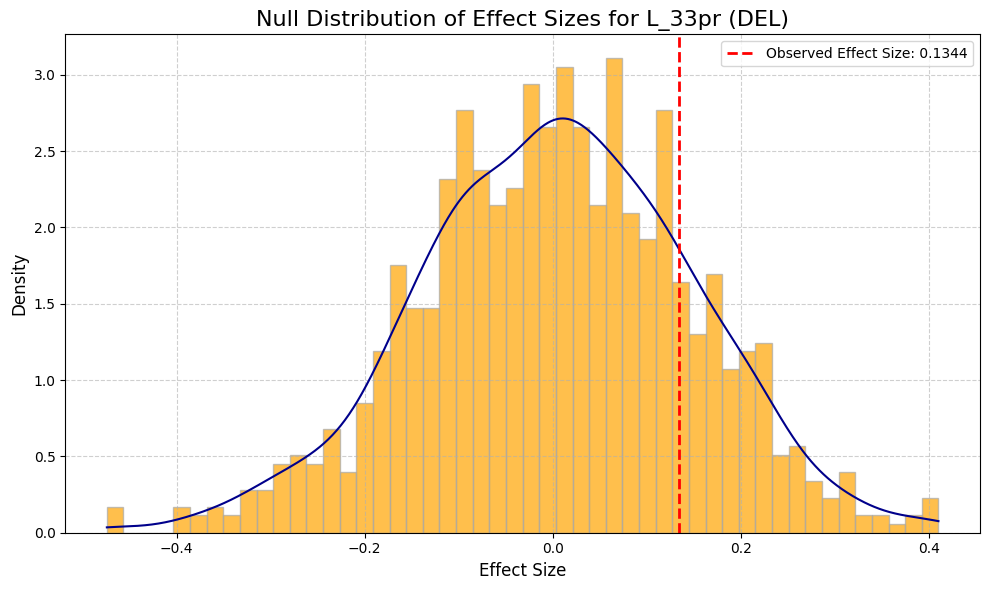

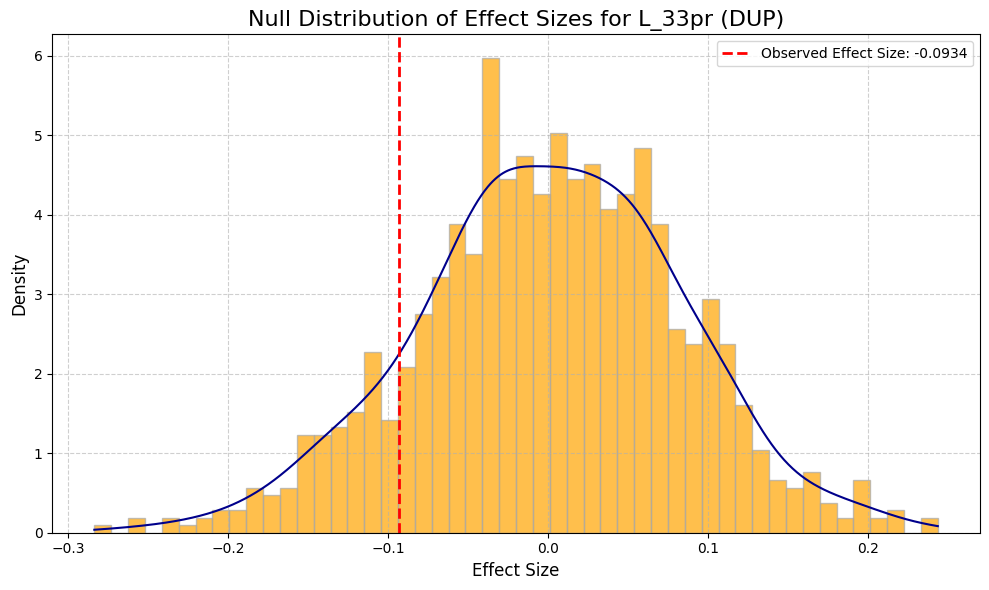

Finished processing L_33pr in 22.88 seconds.


In [16]:
# Example 1: Call the permutation test function for a specific brain gene set L_33pr ##
results = Association_Test_Permutation('L_33pr.tsv')


In [17]:
results

Effectsize        se    pvalue  pvalue_permutation  CI_lower  CI_upper  \
0    0.134356  0.143840  0.351220            0.343656 -0.295481  0.275667   
1   -0.093428  0.084514  0.270074            0.257742 -0.167638  0.163646   

  TYPE gene_list_name  
0  DEL         L_33pr  
1  DUP         L_33pr

Processing gene list: L_PCV.tsv


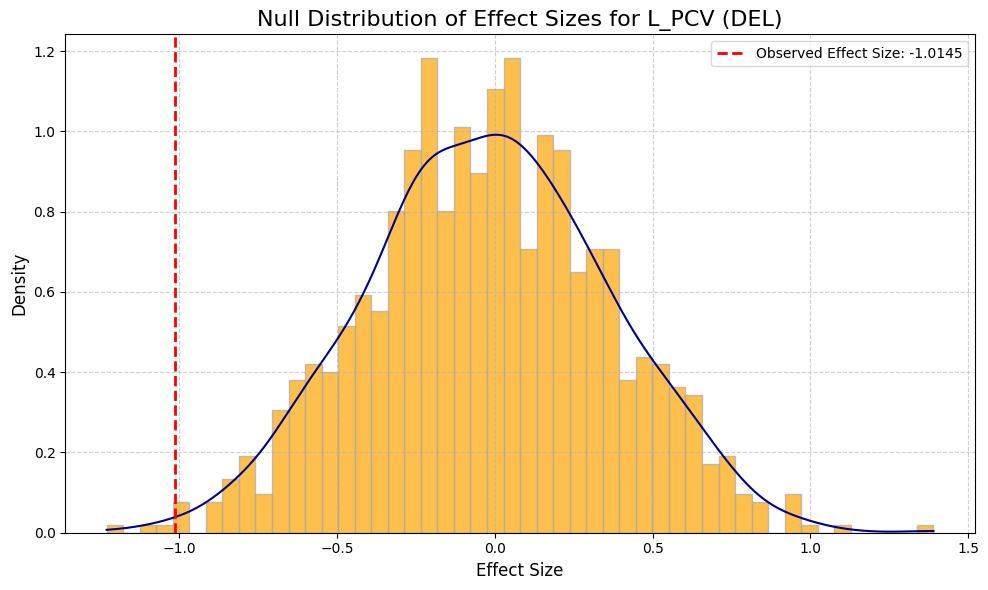

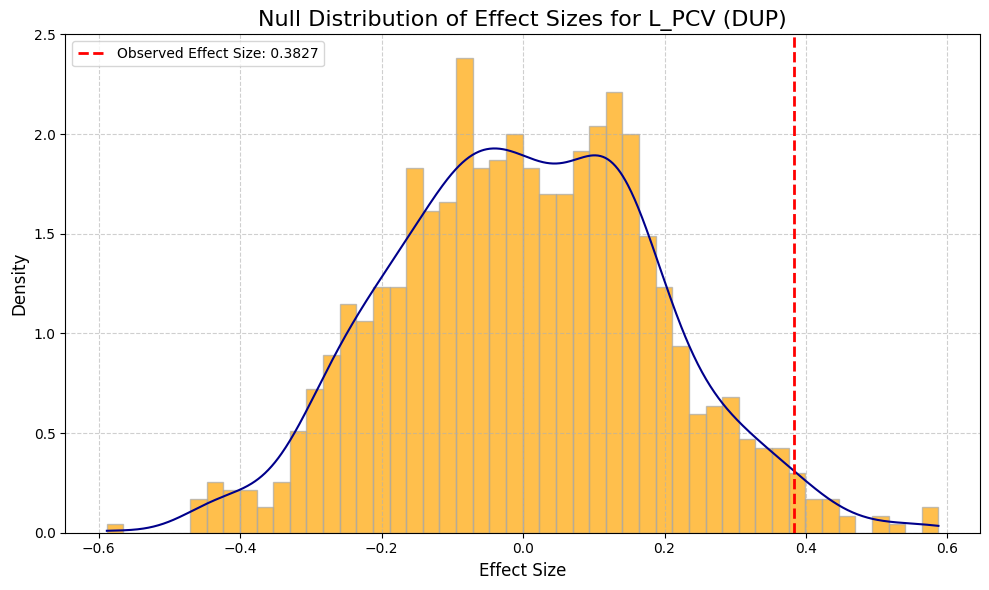

Finished processing L_PCV in 22.91 seconds.


In [18]:
# Example 2: Call the permutation test function for a specific brain gene set L_PCV ##
results = Association_Test_Permutation('L_PCV.tsv')

In [19]:
results

Effectsize        se    pvalue  pvalue_permutation  CI_lower  CI_upper  \
0   -1.014531  0.381402  0.008347            0.005994 -0.785201  0.723583   
1    0.382743  0.181214  0.035724            0.041958 -0.346797  0.372502   

  TYPE gene_list_name  
0  DEL          L_PCV  
1  DUP          L_PCV